### Imports

In [1]:
spark.version

u'2.2.0'

In [2]:
import re
import datetime
from pyspark.sql.functions import *
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import DoubleType, IntegerType, StringType,DateType
import pandas as pd
pd.set_option('display.max_colwidth', 80)
pd.set_option('display.max_columns', 50)


from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import PolynomialExpansion
from pyspark.ml.regression import LinearRegression

import numpy as np
import seaborn as sns
sns.set_palette("deep", desat=0.6)
sns.set_context(rc={"figure.figsize": (8,4)})

import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline

### Load In NBA Score Data Set

In [133]:
cleaned_dir = '/data2/nba-rt-prediction/sparkfiles/cleanedDF'
df = spark.read.format('csv')\
                    .option("header", "true")\
                    .option("inferSchema", "true")\
                    .option("dateFormat", "yyyy-MM-dd")\
                    .load(cleaned_dir).repartition(2)

                # For some reason my key is none upon load ! Rebuild
df = df.withColumn("key", concat(date_format(df.dateOrig, "yyyy-MM-dd"),lit("."),col("away_team"),lit("."),col("home_team")))

#New TARGET Variable!
df = df.withColumn("label_home_pts_lts", col("final_home_score") - (col("home_score") ))  
df = df.withColumn("label_away_pts_lts", col("final_away_score") - (col("away_score") ))  
# Projected score based on spread // overunder
df = df.withColumn("home_partial_proj", (col("pct_left")/100)*(col("overunder")/2 - col("home_team_spread") /2 ))  
df = df.withColumn("away_partial_proj", (col("pct_left")/100)*(col("overunder")/2 - col("away_team_spread") /2 )) 
# Projected score based avg scoring for game so far 
df = df.withColumn("home_partial_proj2", (col("home_score") /  (col("pct_complete") + 0.01)) * col("pct_left") )
df = df.withColumn("away_partial_proj2", (col("away_score") /  (col("pct_complete") + 0.01)) * col("pct_left") )
#since the above projections blows up for beginning of the game, clip it with spread ...
df = df.withColumn("home_partial_proj2_clip", when(col("pct_complete") < 33, col("home_partial_proj")).otherwise(col("home_partial_proj2")) )  
df = df.withColumn("away_partial_proj2_clip", when(col("pct_complete") < 33, col("away_partial_proj")).otherwise(col("away_partial_proj2")) )  


# Convert N min score difference to a final score project for pct of game left, 3min~ 6.25%, 6min, 12.5 pct
df = df.withColumn("asm_3min_partial_proj", col("pct_left")*(col("asm_3min")/ lit(6.25))) 
df = df.withColumn("asm_6min_partial_proj", col("pct_left")*(col("asm_6min")/ lit(12.5))) 
df = df.withColumn("asm_9min_partial_proj", col("pct_left")*(col("asm_9min")/ lit(18.75))) 

df = df.withColumn("home_3min_partial_proj", col("pct_left")*(col("home_3min_abs") / lit(6.25))) 
df = df.withColumn("home_6min_partial_proj", col("pct_left")*(col("home_6min_abs") / lit(12.5))) 
#df = df.withColumn("home_9min_partial_proj", col("pct_left")*(col("home_9min_abs") / lit(12.5))) 
df = df.withColumn("away_3min_partial_proj", col("pct_left")*(col("away_3min_abs") / lit(6.25))) 
df = df.withColumn("away_6min_partial_proj", col("pct_left")*(col("away_6min_abs") / lit(12.5))) 


#df.printSchema()
#df.toPandas()
#df.sample(0.001,).toPandas()
junk, showdata = df.randomSplit([0.999, 0.001], seed = 82)
showdata.toPandas()

,dateOrig,ts,away_team_full,away_score,home_team_full,home_score,timestring,timeleft,away_team,home_team,score_diff_amh,date,time_elapsed,pct_complete,pct_left,pct_complete_inv,pct_left_inv,home_points_per_pct,away_points_per_pct,FNL,Q4,Q3,Q2,Q1,home_3min_abs,...,away_team_ml,home_team_spread,home_team_ml,dateStr,away_team_vegas_fscore,home_team_vegas_fscore,final_away_score,final_home_score,away_win,home_win,dfa,outlier,key,label_home_pts_lts,label_away_pts_lts,home_partial_proj,away_partial_proj,home_partial_proj2,away_partial_proj2,home_partial_proj2_clip,away_partial_proj2_clip,home_3min_partial_proj,home_6min_partial_proj,away_3min_partial_proj,away_6min_partial_proj
0,2016-04-05,21:21:38,Cleveland,71.600000,Milwaukee,50.000000,(9:26 IN 3RD),21.5,cle,mil,21.600000,2016-04-05,26.5,55.208333,44.791667,0.018113,0.022325,0.905644,1.296882,0,0,1,0,0,8.507692,...,-340,7.50,280,2016-04-05,105.25,97.75,109,80,1,0,-17.256250,0,2016-04-05.cle.mil,30.000000,37.400000,43.783854,47.143229,40.558691,58.080046,40.558691,58.080046,60.971795,57.333333,43.771795,63.066667
1,2016-04-06,21:58:19,Houston,17.485714,Dallas,13.000000,(3:42 IN 1ST),40.0,hou,dal,4.485714,2016-04-06,8.0,16.666667,83.333333,0.059996,0.012000,0.779953,1.049080,0,0,0,0,1,2.892857,...,-120,1.00,0,2016-04-06,105.00,104.00,86,88,0,1,-1.485714,0,2016-04-06.hou.dal,75.000000,68.514286,86.666667,87.500000,64.961023,87.376146,86.666667,87.500000,38.571429,33.333333,19.809524,23.238095
2,2016-04-07,20:43:43,Toronto,24.000000,Atlanta,35.000000,(8:26 IN 2ND),32.5,tor,atl,-11.000000,2016-04-07,15.5,32.291667,67.708333,0.030967,0.014769,1.083837,0.743203,0,0,0,1,0,4.044534,...,250,-7.00,-300,2016-04-07,96.50,103.50,87,95,0,1,-0.229167,0,2016-04-07.tor.atl,60.000000,63.000000,70.078125,65.338542,73.364377,50.307002,70.078125,65.338542,43.815789,69.513889,43.333333,44.236111
3,2016-04-13,22:59:44,Utah,6.000000,LA Lakers,4.000000,(5:20 IN 1ST),41.5,uta,lal,2.000000,2016-04-13,6.5,13.541667,86.458333,0.073841,0.011566,0.295363,0.443044,0,0,0,0,1,2.000000,...,-210,5.00,175,2016-04-13,99.25,94.25,96,101,0,1,16.677083,0,2016-04-13.uta.lal,97.000000,90.000000,81.486979,85.809896,25.519616,38.279424,81.486979,85.809896,27.666667,27.666667,0.000000,4.788462
4,2016-04-21,00:22:34,Portland,43.235294,LA Clippers,47.238562,(5:24 IN 3RD),23.5,por,lac,-4.003268,2016-04-20,24.5,51.041667,48.958333,0.019591,0.020425,0.925472,0.847042,0,0,1,0,0,3.856209,...,335,-8.50,-425,2016-04-20,100.25,108.75,81,102,0,1,2.932394,0,2016-04-21.por.lac,54.761438,37.764706,53.242188,49.080729,45.301582,41.462465,45.301582,41.462465,30.206972,26.431100,27.647059,24.191176
5,2016-04-24,14:04:12,San Antonio,27.666667,Memphis,27.000000,(7:35 IN 2ND),32.5,san,mem,0.666667,2016-04-24,15.5,32.291667,67.708333,0.030967,0.014769,0.836103,0.856748,0,0,0,1,0,6.235294,...,-110,13.00,-110,2016-04-24,98.00,85.00,116,95,1,0,13.468750,0,2016-04-24.san.mem,68.000000,88.333333,57.552083,66.354167,56.595377,57.992794,57.552083,66.354167,67.549020,68.143601,28.888889,34.998760
6,2016-04-06,00:00:33,Portland,32.638161,Sacramento,31.585317,(6:41 IN 4TH),33.5,por,sac,1.052844,2016-04-05,14.5,30.208333,69.791667,0.033102,0.014328,1.045548,1.080400,0,0,0,1,0,3.267447,...,-155,3.00,135,2016-04-05,113.00,110.00,115,107,1,0,2.839023,0,2016-04-06.por.sac,75.414683,82.361839,76.770833,78.864583,72.948824,75.380452,76.770833,78.864583,36.486486,36.486486,37.702703,37.702703
7,2016-04-07,21:45:48,Phoenix,77.000000,Houston,79.000000,(3:35 IN 3RD),16.0,pho,hou,-2.000000,2016-04-07,32.0,66.666667,33.333333,0.015000,0.029999,1.184982,1.154983,0,0,1,0,0,4.000000,...,-110,-12.00,-110,2016-04-07,100.75,112.75,124,115,1,0,3.333333,0,2016-04-07.pho.hou,36.000000,47.000000,37.583333,33.583333,39.494076,38.494226,39.494076,38.494226,21.333333,32.000000,69.333333,53.333333
8,2016-04-13,00:57:26,Memphis,82.562874,LA Clippers,103.532934,(0:00 IN 4TH),2.0,mem,lac,-20.970060,2016-04-12,46.0,95.833333,4.166667,0.010435,0.239942,1.080332,0.861517,0,1,0,0,0,7.22043

### Create Train / cv or Dev / Test Sets
#### What is unique here, is that games should be randomized, not points in games, as points in games are correlated !

In [134]:
#trainingData, testData = df.randomSplit([0.7, 0.3], seed = 82)
#print "Training set size: " + str(trainingData.count())
#print "Testing set size: " + str(testData.count())
##print "Distribution of Default and Non-Default in trainingData is: ", trainingData.groupBy("label").count().take(3)

#TODO, add key code here ....
ddf = df.select(['key']).distinct()
trainingGames, testGames = ddf.randomSplit([0.7, 0.3], seed = 82)

trainingData = df.join(trainingGames, df["key"] == trainingGames["key"], "inner").drop(trainingGames["key"]).cache()
testData = df.join(testGames, df["key"] == testGames["key"], "inner").drop(testGames["key"]).cache()
print "Training set size: " + str(trainingData.count())
print "Testing set size: " + str(testData.count())


Training set size: 7841
Testing set size: 3529


### Logistic Regression to predict outcome

In [124]:
def logr_train_and_test(f_cols,trainingData,testData):
    

    assembler = VectorAssembler(inputCols=f_cols, outputCol="features")
    polyExpansion = PolynomialExpansion(degree=3, inputCol="features", outputCol="polyFeatures")
    scaler = StandardScaler(withMean=False, withStd=True, inputCol="polyFeatures", outputCol="features_scaled")
    # Create initial LogisticRegression model
    lr = LogisticRegression(labelCol="home_win", featuresCol="features_scaled", threshold=0.5,regParam=0.05)
    pipeline_lr = Pipeline(stages=[assembler,polyExpansion,scaler, lr])
    #model_lr = pipeline_lr.fit(trainingData)

    # Create ParamGrid for Cross Validation
    paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01,0.03])
             .addGrid(lr.elasticNetParam, [0.0])
             .addGrid(lr.maxIter, [100])
             .build())
    
    lr_evaluator = BinaryClassificationEvaluator(labelCol="home_win",metricName="areaUnderROC")
    
    # Create 5-fold CrossValidator
    lr_cv = CrossValidator(estimator=pipeline_lr, estimatorParamMaps=paramGrid, evaluator=lr_evaluator, numFolds=2)

    # Run cross validations
    lrCvModel = lr_cv.fit(trainingData)
    
    predictions = lrCvModel.transform(testData)

    areaUnderROC = lr_evaluator.evaluate(predictions)

    
    print "areaUnderROC for Logistic Regression: " + str(areaUnderROC) #0.6918242957971713
    print "Cross tab for prediction vs actual table"
    crosstab = lrCvModel.transform(testData).stat.crosstab("home_win", "prediction")
    crosstab.show()
    # Calculate Accuracy
    tp = float(crosstab.toPandas().values[0][2])
    tn = float(crosstab.toPandas().values[1][1])
    tot = float(np.sum(crosstab.toPandas().values[0:2,1:3]))
    accuracy = (tp+tn)/tot
    print "Accuracy = " + str(accuracy)

    return (crosstab,areaUnderROC,predictions,lrCvModel)


In [10]:
# Run Logistic Regression
logr_results_dict = {}

for i in range(0:5) :
    logr_results_dict['model'+i] = logr_train_and_test(feature_cols[i],trainingData,testData)


SyntaxError: invalid syntax (<ipython-input-10-edab87d6097a>, line 4)

### Linear Regression to Predict Score for Home and Away Team

In [135]:
#Create Feature Columns for experiments
feature_cols = []


feature_cols.append(["home_score", "pct_complete"])
feature_cols.append(["home_score", "pct_complete", "overunder", "home_team_spread"])
feature_cols.append(["home_partial_proj"])
feature_cols.append(["home_partial_proj2_clip"])
feature_cols.append(["home_partial_proj", "home_partial_proj2_clip"])
feature_cols.append(["home_partial_proj", "home_partial_proj2_clip","home_6min_partial_proj"])
feature_cols.append(["home_partial_proj", "home_partial_proj2_clip","home_6min_partial_proj","asm_3min_partial_proj", "asm_6min_partial_proj", "asm_9min_partial_proj"])



#feature_cols.append(["home_score", "away_score", "pct_complete"])
#feature_cols.append(["home_score", "away_score", "pct_complete", "pct_complete_inv"])
#feature_cols.append(["home_score", "away_score", "pct_complete", "pct_complete_inv", "home_points_per_pct", "away_points_per_pct"])
#feature_cols.append(["home_score", "away_score", "pct_complete", "pct_complete_inv", "home_points_per_pct", "away_points_per_pct", "overunder"])

#feature_cols.append(["home_score", "away_score", "score_diff_amh", "pct_complete"])
#feature_cols.append(["home_score", "away_score", "score_diff_amh", "home_team_spread","pct_complete"])
#feature_cols.append(["home_score", "away_score", "score_diff_amh", "home_team_spread","pct_complete", "cf1", "cf2"])
#feature_cols.append(["home_score", "away_score", "score_diff_amh", "home_team_spread","pct_complete", "cf1", "cf2","asm_3min","asm_6min","asm_9min"])


In [136]:
def linreg_train_and_test(f_cols,labelCol,trainingData,testData):
    
    assembler = VectorAssembler(inputCols=f_cols, outputCol="features")
    polyExpansion = PolynomialExpansion(degree=1, inputCol="features", outputCol="polyFeatures")
    scaler = StandardScaler(withMean=False, withStd=False, inputCol="polyFeatures", outputCol="features_scaled")
    # Create initial LogisticRegression model
    linreg = LinearRegression(labelCol=labelCol,featuresCol="features_scaled",fitIntercept=False)
    
    pipeline = Pipeline(stages=[assembler,polyExpansion,scaler, linreg])

    # Create ParamGrid for Cross Validation
    paramGrid = (ParamGridBuilder()
             .addGrid(linreg.regParam, [0.01,0.1,1.0])
             .addGrid(linreg.elasticNetParam, [0.0])
             .addGrid(linreg.maxIter, [200])
             .build())
    
    linreg_evaluator = RegressionEvaluator(labelCol=labelCol,metricName="mse")
    
    # Create N-fold CrossValidator
    linreg_cv = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=linreg_evaluator, numFolds=2)

    # Run cross validations
    linregCvModel = linreg_cv.fit(trainingData)
    
    predictions = linregCvModel.transform(testData)

    linreg_mse = linreg_evaluator.evaluate(predictions)

    print "MSE for Linear Regression: " + str(linreg_mse) 
    
    return (linreg_mse,predictions,linregCvModel)

In [137]:
linreg_results_dict = {}

for i in range(0,6) :
    print "Home / Away for features " + str(feature_cols[i])
    
    linreg_results_dict['home_model'+str(i)] = linreg_train_and_test(feature_cols[i],"label_home_pts_lts",trainingData,testData)
    away_features = [ x.replace('home','away') for x in feature_cols[i]]
    linreg_results_dict['away_model'+str(i)] = linreg_train_and_test(away_features,"label_away_pts_lts",trainingData,testData)


Home / Away for features ['home_score', 'pct_complete']
MSE for Linear Regression: 2949.22647226
MSE for Linear Regression: 2470.65342605
Home / Away for features ['home_score', 'pct_complete', 'overunder', 'home_team_spread']
MSE for Linear Regression: 91.6342383777
MSE for Linear Regression: 100.413051437
Home / Away for features ['home_partial_proj']
MSE for Linear Regression: 56.8101626719
MSE for Linear Regression: 70.2907351923
Home / Away for features ['home_partial_proj2_clip']
MSE for Linear Regression: 81.5215121229
MSE for Linear Regression: 93.7426226032
Home / Away for features ['home_partial_proj', 'home_partial_proj2_clip']
MSE for Linear Regression: 56.9282514171
MSE for Linear Regression: 70.6234593574
Home / Away for features ['home_partial_proj', 'home_partial_proj2_clip', 'home_6min_partial_proj']
MSE for Linear Regression: 57.3038666786
MSE for Linear Regression: 70.5554411157


In [112]:
### Look at the Coefficients
best_model = linreg_results_dict["home_model0"][2]
linreg_mdl = best_model.bestModel.stages[3]
print linreg_mdl.coefficients
print linreg_mdl.intercept

#best_model = linreg_results_dict["away_model0"][2]
#linreg_mdl = best_model.bestModel.stages[3]
#print linreg_mdl.coefficients
#
#best_model = linreg_results_dict["home_model3"][2]
#linreg_mdl = best_model.bestModel.stages[3]
#print linreg_mdl.coefficients
#best_model = linreg_results_dict["away_model3"][2]
#linreg_mdl = best_model.bestModel.stages[3]
#print linreg_mdl.coefficients



testData.toPandas().describe()

[0.965983507009]
0.0


,away_score,home_score,timeleft,score_diff_amh,time_elapsed,pct_complete,pct_left,pct_complete_inv,pct_left_inv,home_points_per_pct,away_points_per_pct,FNL,Q4,Q3,Q2,Q1,home_3min_abs,home_6min_abs,away_3min_abs,away_6min_abs,amh_3min,asm_3min,amh_6min,asm_6min,amh_9min,...,asm_9min_partial_proj,cf1,cf2,away_team_spread,overunder,away_team_ml,home_team_spread,home_team_ml,away_team_vegas_fscore,home_team_vegas_fscore,final_away_score,final_home_score,away_win,home_win,dfa,outlier,label_home_pts_lts,label_away_pts_lts,home_partial_proj,away_partial_proj,home_partial_proj2,home_partial_proj2_clip,away_partial_proj2,home_3min_partial_proj,home_6min_partial_proj
count,3529.000000,3529.000000,3529.000000,3529.000000,3529.000000,3529.000000,3529.000000,3529.000000,3529.000000,3529.000000,3529.000000,3529.000000,3529.000000,3529.000000,3529.000000,3529.000000,3529.000000,3529.000000,3529.000000,3529.000000,3529.000000,3529.000000,3529.000000,3529.000000,3529.000000,...,3529.000000,3529.000000,3529.000000,3529.000000,3529.000000,3529.000000,3529.000000,3529.000000,3529.000000,3529.000000,3529.000000,3529.000000,3529.000000,3529.000000,3529.000000,3529,3529.000000,3529.000000,3529.000000,3529.000000,3529.000000,3529.000000,3529.000000,3529.000000,3529.000000
mean,46.687228,52.223518,24.400255,-5.536290,23.599745,49.166135,50.833865,10.253733,20.450463,1.063924,0.938858,0.020402,0.241712,0.232077,0.257580,0.258430,5.505941,10.692913,5.005851,9.715327,-5.036200,-0.500090,-4.558703,-0.977586,-3.683049,...,-4.773916,-7.491758,-60.085913,4.256329,204.749504,-8.593558,-4.256329,-105.562010,100.246588,104.502916,95.396996,105.325871,0.278266,0.721734,-0.357632,0,53.102354,48.709768,53.265603,50.951530,54.127964,51.643422,103.060096,42.393151,39.970443
std,28.917382,31.951496,14.126633,11.850038,14.126633,29.430485,29.430485,100.493428,141.385422,0.264455,0.236052,0.141392,0.428181,0.422218,0.437363,0.437834,2.901423,4.802756,2.891404,4.830325,11.359829,3.466032,10.782671,4.971124,9.513480,...,18.547144,29.601497,984.902437,8.876830,9.964871,224.318410,8.876830,226.852694,5.551718,7.630650,12.537052,12.005352,0.448209,0.448209,6.323398,0,31.860607,29.201598,31.289864,29.677508,37.557462,32.091507,59.994840,33.711115,28.876789
min,0.000000,0.000000,0.000000,-42.882353,0.000000,0.000000,0.000000,0.010000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.125689,0.000000,0.000000,0.000000,-43.642857,-15.636364,-43.642857,-18.000000,-40.941176,...,-88.000000,-380.000000,-15128.072481,-13.000000,183.000000,-535.000000,-19.000000,-650.000000,84.375000,85.000000,68.000000,84.000000,0.000000,0.000000,-36.594575,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-9.789360,0.000000
25%,22.000000,24.500000,12.000000,-12.370558,11.500000,23.958333,25.000000,0.013333,0.013151,0.926935,0.835804,0.000000,0.000000,0.000000,0.000000,0.000000,3.452566,7.000000,2.969697,6.000000,-11.793103,-2.241379,-10.629630,-3.294118,-8.371429,...,-13.283071,-10.447591,-0.292018,-3.500000,200.000000,-126.666667,-11.750000,-200.000000,97.000000,100.750000,86.000000,95.000000,0.000000,0.000000,-3.475694,0,25.070404,23.102041,26.236979,25.335938,24.644555,24.644555,51.250000,16.000000,16.841530
50%,45.000000,51.750000,25.000000,-4.166667,23.000000,47.916667,52.083333,0.020869,0.019200,1.077322,0.954389,0.000000,0.000000,0.000000,0.000000,0.000000,5.050000,10.654631,4.764706,9.728223,-3.250000,-0.587276,-2.416667,-1.125000,-0.793157,...,-2.595263,-2.717930,-0.046369,5.000000,206.500000,-110.000000,-5.000000,-110.000000,100.250000,104.000000,98.000000,108.000000,0.000000,1.000000,0.000000,0,53.595263,49.200000,54.231771,52.083333,50.665309,50.665309,105.320312,35.486936,35.833333
75%,69.000000,78.000000,36.500000,1.180723,36.000000,75.000000,76.041667,0.041737,0.039998,1.190268,1.067226,0.000000,0.000000,0.000000,1.000000,1.000000,7.598978,14.117647,7.000000,13.000000,1.000000,1.361111,0.577778,1.626263,0.000000,...,3.121639,0.912374,0.016051,11

### Plot the residuals

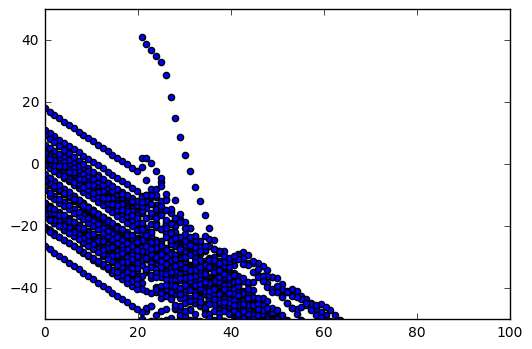

In [120]:
predictions_pd = linreg_results_dict["home_model1"][1].toPandas()

plt.xlim(0, 100)
plt.ylim(-50, 50)
plt.scatter(predictions_pd.pct_complete,predictions_pd.prediction-predictions_pd.final_home_score)

#plt.xlim(50, 150)
#plt.ylim(50, 150)
#plt.scatter(predictions_pd.prediction, predictions_pd.final_home_score)


In [121]:
cols = feature_cols[4][:] + ["label_home_pts_lts","prediction", "timeleft","home_score"]
predictions_pd[(predictions_pd.key == "2016-04-08.ind.tor")][cols]

,home_partial_proj,home_partial_proj2_clip,home_6min_partial_proj,asm_3min_partial_proj,asm_6min_partial_proj,asm_9min_partial_proj,label_home_pts_lts,prediction,timeleft,home_score
1605,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.0,111.000000
1606,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.0,111.000000
1607,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,111.000000
1608,1.973958,2.276363,2.425000,0.444444,0.908333,0.777778,4.000000,2.168716,1.0,107.000000
1609,3.947917,4.564741,5.333333,1.400000,1.580247,0.844444,6.000000,4.348879,2.0,105.000000
1610,5.921875,6.865934,7.000000,3.641026,2.000000,0.333333,8.000000,6.541251,3.0,103.000000
1611,7.895833,9.029318,9.555556,5.488889,1.777778,1.629630,11.666667,8.602331,4.0,99.333333
1612,9.869792,11.289437,12.479167,4.401235,-2.479167,-1.015152,13.900000,10.755571,5.0,97.100000
1613,11.843750,13.855559,15.000000,0.717949,-2.641026,-4.627350,14.000000,13.200344,6.0,97.000000
1614,13.817708,15.782299,12.191667,-3.383333,1.808333,-6.480719,18.550000,15.035969,7.0,92.450000


### Linear Error Analysis

In [123]:
vis_df = linreg_results_dict["home_model0"][1]
vis_df = vis_df.select(["key","away_score","home_score","pct_complete","final_home_score","prediction"]). \
  withColumn("residual_sq", \
             ((col("final_home_score") - col("prediction")) * (col("final_home_score") - col("prediction"))))
    
vis_pd = vis_df.toPandas()
    
#plt.figure()
#plt.scatter(vis_pd.away_score, vis_pd.home_score,c=vis_pd.correct)
#ax = plt.scatter(vis_pd.pct_complete, vis_pd.final_home_score,c='red')
#ax.legend(['1stSerie','2ndSerie'])

vis_df.registerTempTable("vis_df")
spark.sql("SELECT key, SUM(residual_sq) as sumsq, COUNT(key) FROM vis_df GROUP BY key ORDER BY sumsq DESC").show()

# Close Game
#spark.sql("SELECT * FROM predictions WHERE key='2016-04-18.dal.okc'").toPandas()
# 
#spark.sql("SELECT * FROM predictions WHERE key='2016-04-13.mia.bos'").toPandas()


+------------------+------------------+----------+
|               key|             sumsq|count(key)|
+------------------+------------------+----------+
|2016-04-08.ind.tor|22084.193510435543|       101|
|2016-04-12.phi.tor|20907.663728858577|        98|
|2016-04-23.okc.dal|15097.561055628725|        97|
|2016-04-10.bkn.ind|13808.946232701957|        97|
|2016-04-06.hou.dal|10876.113072001615|        95|
|2016-04-17.mem.san|10820.894661057751|        97|
|2016-04-24.san.mem|10688.656204120609|        97|
|2016-04-18.dal.okc| 9822.059389961789|        97|
|2016-04-10.cha.wsh| 8720.147933016538|        97|
|2016-04-16.hou.gst| 7321.328178905849|        98|
|2016-04-08.lal.nor| 6155.356235431426|        97|
|2016-04-13.mia.bos| 5472.219791074685|        97|
|2016-04-13.mem.lac| 5429.486657126678|        97|
|2016-04-08.san.gst| 5104.633512679031|        97|
|2016-04-05.san.uta| 5093.522833422048|        97|
|2016-04-14.lac.pho| 4949.235043704369|        97|
|2016-04-10.uta.den|4583.997802

In [115]:
predictions_pd = linreg_results_dict["home_model4"][1].toPandas()

plt.xlim(90, 100)
plt.ylim(-30, 30)
ax=plt.scatter(predictions_pd.pct_complete,predictions_pd.prediction-predictions_pd.final_home_score)

KeyError: 'home_model4'

### Logistic Error Analysis

+------------------+-------------------+------------+--------------+
|               key|       avg(correct)|sum(correct)|count(correct)|
+------------------+-------------------+------------+--------------+
|2016-04-13.sac.hou|                1.0|       100.0|           100|
|2016-04-13.mia.bos|0.44329896907216493|        43.0|            97|
|2016-04-09.gst.mem| 0.9278350515463918|        90.0|            97|
|2016-04-13.mem.gst|                1.0|        48.0|            48|
|2016-04-13.orl.cha|                1.0|        97.0|            97|
|2016-04-21.tor.ind| 0.9175257731958762|        89.0|            97|
|2016-04-14.lac.pho|                1.0|        97.0|            97|
|2016-04-22.cle.det| 0.6701030927835051|        65.0|            97|
|2016-04-16.hou.gst|                1.0|        98.0|            98|
|2016-04-24.san.mem|                1.0|        97.0|            97|
|2016-04-06.hou.dal| 0.6631578947368421|        63.0|            95|
|2016-04-24.lac.por| 0.93814432989

,dateOrig,ts,away_team_full,away_score,home_team_full,home_score,timestring,timeleft,away_team,home_team,score_diff_amh,date,time_elapsed,pct_complete,pct_left,amh_3min,asm_3min,amh_6min,asm_6min,amh_9min,asm_9min,cf1,cf2,away_team_spread,overunder,away_team_ml,home_team_spread,home_team_ml,dateStr,away_team_vegas_fscore,home_team_vegas_fscore,final_away_score,final_home_score,away_win,home_win,dfa,outlier,key,features,polyFeatures,features_scaled,rawPrediction,probability,prediction
0,2016-04-13,22:29:17,Miami,88.000000,Boston,98.000000,(0:00 IN 4TH),0.0,mia,bos,-10.000000,2016-04-13,48.0,100.000000,0.000000,-8.000000,-2.000000,-5.555556,-4.444444,4.000000,-14.000000,-100.000000,-3981.071706,5,206.5,170,-5,-200,2016-04-13,100.75,105.75,88,98,0,1,0.000000,0,2016-04-13.mia.bos,"[98.0, 88.0, -10.0, -5.0, 100.0, -100.0, -3981.07170553, -2.0, -4.4444444444...","[98.0, 9604.0, 941192.0, 88.0, 8624.0, 845152.0, 7744.0, 758912.0, 681472.0,...","[3.13695055962, 2.74849518143, 2.4953165513, 2.89666299668, 2.65912274368, 2...","[-10.0210392785, 10.0210392785]","[4.44527499289e-05, 0.99995554725]",1
1,2016-04-13,22:27:46,Miami,87.833333,Boston,96.000000,(0:29 IN 4TH),0.5,mia,bos,-8.166667,2016-04-13,47.5,98.958333,1.041667,-8.000000,-0.166667,-5.066667,-3.100000,4.000000,-12.166667,-35.928543,-18.603694,5,206.5,170,-5,-200,2016-04-13,100.75,105.75,88,98,0,1,0.229167,0,2016-04-13.mia.bos,"[96.0, 87.8333333333, -8.16666666667, -5.0, 98.9583333333, -35.9285431802, -...","[96.0, 9216.0, 884736.0, 87.8333333333, 8432.0, 809472.0, 7714.69444444, 740...","[3.07293116044, 2.637456434, 2.34563870532, 2.89117689252, 2.59992149521, 2....","[-4.4943577775, 4.4943577775]","[0.0110484217817, 0.988951578218]",1
2,2016-04-13,22:24:13,Miami,84.000000,Boston,93.090909,(0:50 IN 4TH),1.0,mia,bos,-9.090909,2016-04-13,47.0,97.916667,2.083333,-7.106383,-1.984526,-4.000000,-5.090909,4.000000,-13.090909,-29.756985,-8.514630,5,206.5,170,-5,-200,2016-04-13,100.75,105.75,88,98,0,1,5.034091,0,2016-04-13.mia.bos,"[93.0909090909, 84.0, -9.0909090909, -5.0, 97.9166666667, -29.7569850322, -8...","[93.0909090909, 8665.91735537, 806718.124718, 84.0, 7819.63636364, 727937.05...","[2.97981203437, 2.48003249625, 2.13879536678, 2.76499649683, 2.41110539214, ...","[-4.60968381146, 4.60968381146]","[0.00985684094515, 0.990143159055]",1
3,2016-04-13,22:23:42,Miami,83.517241,Boston,90.758621,(1:23 IN 4TH),1.5,mia,bos,-7.241379,2016-04-13,46.5,96.875000,3.125000,-4.000000,-3.241379,-5.000000,-2.241379,4.000000,-11.241379,-19.708538,-4.020254,5,206.5,170,-5,-200,2016-04-13,100.75,105.75,88,98,0,1,5.911638,0,2016-04-13.mia.bos,"[90.7586206897, 83.5172413793, -7.24137931035, -5.0, 96.875, -19.7085381603,...","[90.7586206897, 8237.12722949, 747590.305794, 83.5172413793, 7579.90963139, ...","[2.90515618329, 2.35732033518, 1.98203391406, 2.74910571237, 2.33718809089, ...","[-3.32534899652, 3.32534899652]","[0.0347117338675, 0.965288266133]",1
4,2016-04-13,22:22:42,Miami,81.555556,Boston,89.555556,(1:52 IN 4TH),2.0,mia,bos,-8.000000,2016-04-13,46.0,95.833333,4.166667,-4.000000,-4.000000,-6.000000,-2.000000,4.041667,-12.041667,-19.033238,-3.061964,5,206.5,170,-5,-200,2016-04-13,100.75,105.75,88,98,0,1,7.138889,0,2016-04-13.mia.bos,"[89.5555555556, 81.5555555556, -8.0, -5.0, 95.8333333333, -19.0332380572, -3...","[89.5555555556, 8020.19753087, 718253.245542, 81.5555555556, 7303.75308642, ...","[2.86664642976, 2.29523888669, 1.90425461715, 2.68453363581, 2.25203802717, ...","[-3.50648858755, 3.50648858755]","[0.0291281735892, 0.970871826411]",1
5,2016-04-13,22:20:09,Miami,79.000000,Boston,89.000000,(2:29 IN 4TH),2.5,mia,bos,-10.000000,2016-04-13,45.5,94.791667,5.208333,-4.666667,-5.333333,-4.000000,-6.000000,5.291667,-15.291667,-21.401291,-2.867258,5,206.5,170,-5,-200,2016-04-13,100.75,105.75,88,98,0,1,8.312500,0,2016-04-13.mia.bos,"[89.0, 79.0, -10.0, -5.0, 94.7916666667, -21.4012912502, -2.86725781783, -5....","[89.0, 7921.0, 704969.0, 79.0, 7031.0, 625759.0, 6241.0, 555449.0, 493039.0,..

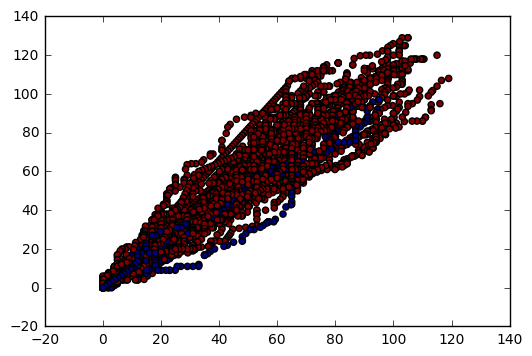

In [49]:
vis_df = results_dict['model4'][2]
vis_df = vis_df.select(["key","away_score","home_score","pct_complete","home_win","prediction"]). \
  withColumn("correct", when(col("home_win") == col("prediction"),1.0).otherwise(0.0))
    
vis_pd = vis_df.toPandas()
    
plt.figure()
plt.scatter(vis_pd.away_score, vis_pd.home_score,c=vis_pd.correct)
#ax = plt.scatter(vis_pd.pct_complete, vis_pd.final_home_score,c='red')
#ax.legend(['1stSerie','2ndSerie'])

vis_df.registerTempTable("vis_df")
results_dict['model4'][2].registerTempTable("predictions")
spark.sql("SELECT key, AVG(correct), SUM(correct),COUNT(correct) FROM vis_df GROUP BY key").show()

# Close Game
spark.sql("SELECT * FROM predictions WHERE key='2016-04-18.dal.okc'").toPandas()
# 
spark.sql("SELECT * FROM predictions WHERE key='2016-04-13.mia.bos'").toPandas()



In [47]:
tp = float(results_dict['model4'][0].toPandas().values[0][2])
tn = float(results_dict['model4'][0].toPandas().values[1][1])

tot = float(np.sum(results_dict['model4'][0].toPandas().values[0:2,1:3]))
(tp+tn)/tot

0.8605837347690564

### Plot a game result

In [ ]:
#df[(df.A == 1) & (df.D == 6)]
vis_pd = predictions_pd[predictions_pd.key == "2016-04-22.san.mem"]
plt.figure()
plt.scatter(vis_pd.pct_complete, vis_pd.prediction,c='green')
ax = plt.scatter(vis_pd.pct_complete, vis_pd.final_home_score,c='red')
ax.legend(['1stSerie','2ndSerie'])
#col("key")
#vis_pd


In [ ]:
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
import numpy as np

# Generate some data
x = np.arange(0, 22, 2)
f1, f2, f3, f4 = np.cumsum(np.random.random((4, x.size)) - 0.5, axis=1)

# It's much more convenient to just use pyplot's factory functions...
fig, ax = plt.subplots()

ax.set_title("Function performance",fontsize=14)
ax.set_xlabel("code executions",fontsize=12)
ax.set_ylabel("time(s)",fontsize=12)
ax.grid(True,linestyle='-',color='0.75')

colors = ['tomato', 'violet', 'blue', 'green']
labels = ['Thing One', 'Thing Two', 'Thing Three', 'Thing Four']
for func, color, label in zip([f1, f2, f3, f4], colors, labels):
    ax.plot(x, func, 'o', color=color, markersize=10, label=label)

ax.legend(numpoints=1, loc='upper left')
ax.set_xlim([0, x.max() + 1])

fig.savefig('performance.png', dpi=100)

In [ ]:
Record Results here ...
wo cfs
RMSE for Linear Regression: 15.7604205578
areaUnderROC for Logistic Regression: 0.942079865694
Cross tab for prediction vs actual table
+-------------------+---+----+
|home_win_prediction|0.0| 1.0|
+-------------------+---+----+
|                1.0| 67|1471|
|                0.0|396| 441|
+-------------------+---+----+

w cfs (explore this ... sigh )
RMSE for Linear Regression: 15.7605249792
    areaUnderROC for Logistic Regression: 0.942253516099
Cross tab for prediction vs actual table
+-------------------+---+----+
|home_win_prediction|0.0| 1.0|
+-------------------+---+----+
|                1.0| 67|1471|
|                0.0|395| 442|
+-------------------+---+----+

w cfs + momentum




In [ ]:
#pyspark.ml.util.MLWriter

model_linr_home.write().overwrite().save("/data2/nba-rt-prediction/spark_models/model_linr_home")
#model_in = PipelineModel.load(outpath)


In [ ]:
predictions_pd